# Imports

In [1]:

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os

from PIL import Image

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint


# Access Dataset
- Within the Dataset, patient age and sex is provided with diagnosis for both the left and right eye being given. One hot encoding is used for the ocular conditions, each condition is represented by its own column where for each image a binary value of 1 or 0 is given to indicate the absence of presence of a disease. The labels coloumn includes the actual diagnosis label for the patient with the target column providing a binary vector representation of the conditions aligning with the individual conditions problem. 




In [2]:
df_data = pd.read_csv('dataset\\full_df.csv')
df_data.head()

,ID,Patient Age,Patient Sex,Left-Fundus,Right-Fundus,Left-Diagnostic Keywords,Right-Diagnostic Keywords,N,D,G,C,A,H,M,O,filepath,labels,target,filename
0,0,69,Female,0_left.jpg,0_right.jpg,cataract,normal fundus,0,0,0,1,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['N'],"[1, 0, 0, 0, 0, 0, 0, 0]",0_right.jpg
1,1,57,Male,1_left.jpg,1_right.jpg,normal fundus,normal fundus,1,0,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['N'],"[1, 0, 0, 0, 0, 0, 0, 0]",1_right.jpg
2,2,42,Male,2_left.jpg,2_right.jpg,laser spot，moderate non proliferative retinopathy,moderate non proliferative retinopathy,0,1,0,0,0,0,0,1,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",2_right.jpg
3,4,53,Male,4_left.jpg,4_right.jpg,macular epiretinal membrane,mild nonproliferative retinopathy,0,1,0,0,0,0,0,1,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",4_right.jpg
4,5,50,Female,5_left.jpg,5_right.jpg,moderate non proliferative retinopathy,moderate non proliferative retinopathy,0,1,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",5_right.jpg


# Preparing the Data 

In [11]:
from ast import literal_eval

# Convert the string representation of one-hot encoded vectors to lists
df_data['target_list'] = df_data['target'].apply(literal_eval)

# Get the index of the '1' in each list which represents the class label
df_data['class_label'] = df_data['target_list'].apply(lambda x: np.argmax(x))

# Now you can use these class labels for stratified sampling
train_df, test_df = train_test_split(
    df_data,
    test_size=0.2,
    random_state=42,
    stratify=df_data['class_label']  # Use the class labels for stratification
)

# Do the same for splitting the training set into training and validation sets
train_df, val_df = train_test_split(
    train_df,
    test_size=0.2,
    random_state=42,
    stratify=train_df['class_label']  # Use the class labels for stratification
)

In [13]:
import os

# Create the directory if it doesn't exist
os.makedirs('dataset/csvs', exist_ok=True)

# Save the CSV files
train_df.to_csv('dataset/csvs/train_df.csv', index=False)
test_df.to_csv('dataset/csvs/test_df.csv', index=False)
val_df.to_csv('dataset/csvs/val_df.csv', index=False)

In [3]:

# Load the CSV files
train_df = pd.read_csv('dataset/csvs/train_df.csv')
test_df = pd.read_csv('dataset/csvs/test_df.csv')
val_df = pd.read_csv('dataset/csvs/val_df.csv')

In [4]:
# Function to load and preprocess images
def parse_image_and_label(image_path, label_string):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [224, 224])
    image = tf.cast(image, tf.float32)
    image = tf.keras.applications.resnet50.preprocess_input(image)  # Preprocessing the image to be compatible with ResNet50
    # Assuming label_string is the string representation of the list (e.g., "[1, 0, 0]")
    label = tf.strings.substr(label_string, 1, tf.strings.length(label_string) - 2)  # Remove brackets
    label = tf.strings.to_number(tf.strings.split(label, ','), out_type=tf.float32)
    return image, label

In [5]:
def load_and_prepare_dataset(df, images_dir, shuffle=True, batch_size=32):
    # Assuming images_dir is the base directory for the images and concatenating it with image filenames
    images_left = images_dir + df['Left-Fundus']
    images_right = images_dir + df['Right-Fundus']

    # Assuming 'target' column contains labels in a string format that needs to be parsed
    labels_left = df['target'].values
    labels_right = df['target'].values

    # Combine the left and right images and labels
    filenames = np.concatenate([images_left, images_right])
    labels = np.concatenate([labels_left, labels_right])

    # Creating TensorFlow dataset
    dataset = tf.data.Dataset.from_tensor_slices((filenames, labels))
    dataset = dataset.map(parse_image_and_label)  # Apply the preprocessing function
    if shuffle:
        dataset = dataset.shuffle(buffer_size=len(df))
    dataset = dataset.batch(batch_size)
    return dataset


In [6]:
train_ds = load_and_prepare_dataset(train_df, 'dataset/ODIR-5K/Training Images/', shuffle=True, batch_size=16)
val_ds = load_and_prepare_dataset(val_df, 'dataset/ODIR-5K/Training Images/', shuffle=False, batch_size=16)
test_ds = load_and_prepare_dataset(test_df, 'dataset/ODIR-5K/Training Images/', shuffle=False, batch_size=16)

In [7]:
print("size of training dataset: ", train_ds.cardinality().numpy())
print("size of validation dataset: ", val_ds.cardinality().numpy())
print("size of test dataset: ", test_ds.cardinality().numpy())

size of training dataset:  512
size of validation dataset:  128
size of test dataset:  160


# Loading and Visualising the Training Data 

Training dataset
(16, 224, 224, 3)
(16, 8)


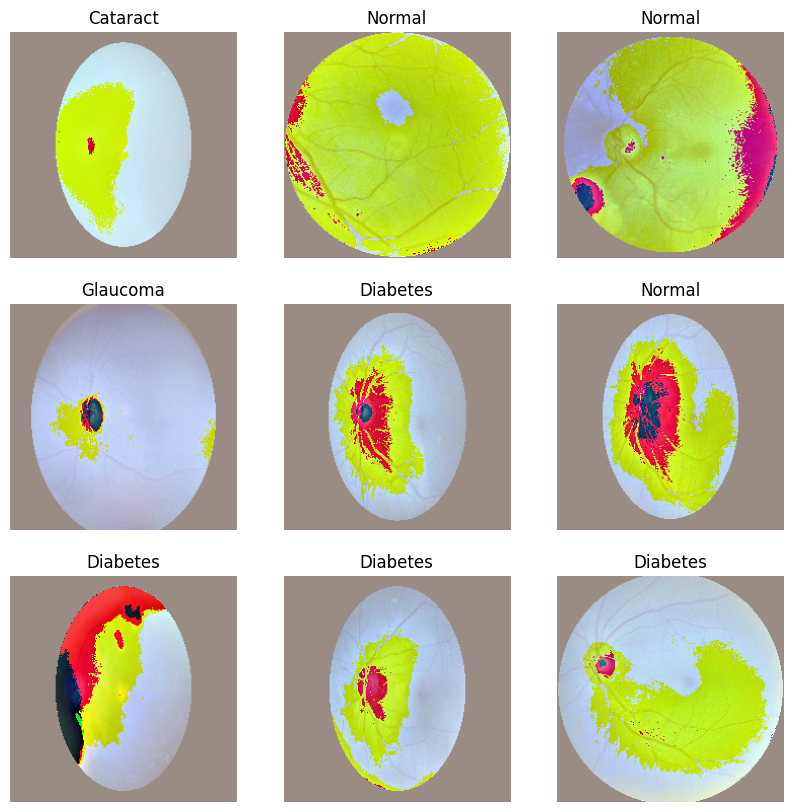

In [8]:
print("Training dataset")
for images, labels in train_ds.take(1):
    print(images.shape)
    print(labels.shape)
# Plotting the first 9 images
plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    class_names = ['Normal', 'Diabetes', 'Glaucoma', 'Cataract', 'AMD', 'Hypertension', 'Myopia', 'Other']
    class_index = np.argmax(labels[i].numpy())
    plt.title(class_names[class_index])

    plt.axis("off")


Validation dataset
(16, 224, 224, 3)
(16, 8)


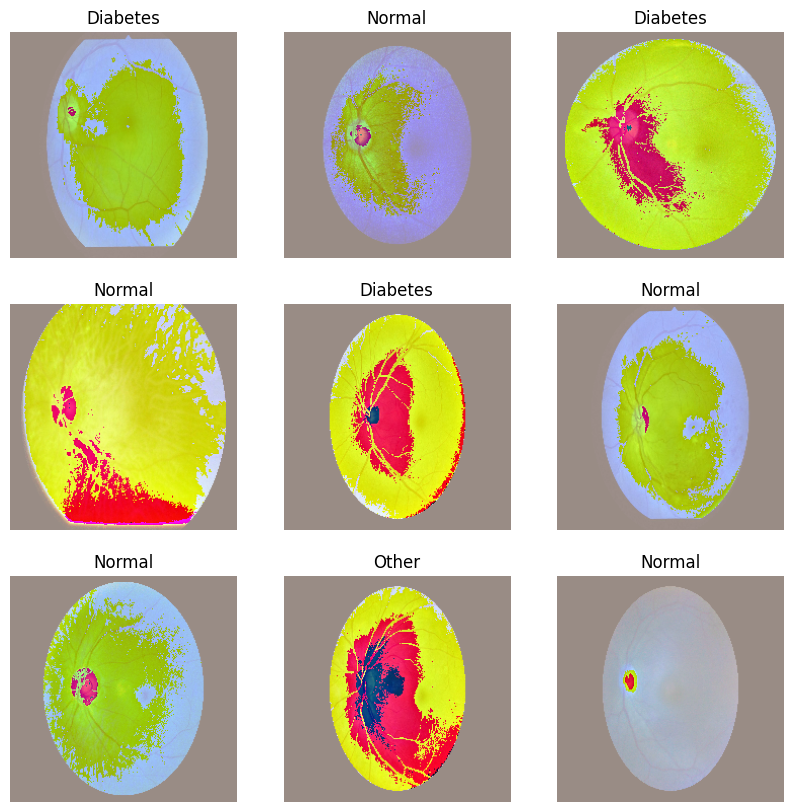

In [9]:
print("Validation dataset")
for images, labels in val_ds.take(1):
    print(images.shape)
    print(labels.shape)
# Plotting the first 9 images
plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    class_names = ['Normal', 'Diabetes', 'Glaucoma', 'Cataract', 'AMD', 'Hypertension', 'Myopia', 'Other']
    class_index = np.argmax(labels[i].numpy())
    plt.title(class_names[class_index])
    plt.axis("off")

In [10]:
# Calculate class weights
def get_class_weights(labels):
    total_samples = len(labels)
    n_classes = len(labels[0])
    class_counts = np.zeros(n_classes)
    for label in labels:
        class_counts += label
    class_weights = total_samples / (n_classes * class_counts)
    return class_weights

# Get the labels from the training dataset
train_labels = []
for _, labels in train_ds:
    train_labels.append(labels.numpy())
train_labels = np.concatenate(train_labels)

# Calculate class weights
class_weights = get_class_weights(train_labels)
print("Class weights:", class_weights)

# Assuming class_weights is the array returned by your function
class_weights_array = get_class_weights(train_labels)

# Convert this array into a dictionary
class_weights_dict = {i: weight for i, weight in enumerate(class_weights_array)}

print("Class weights dictionary:", class_weights_dict)

Class weights: [0.2781556  0.49684159 2.80906593 2.73395722 3.00735294 6.2347561
 3.43120805 1.1285872 ]
Class weights dictionary: {0: 0.27815560391730143, 1: 0.4968415937803693, 2: 2.809065934065934, 3: 2.733957219251337, 4: 3.0073529411764706, 5: 6.234756097560975, 6: 3.4312080536912752, 7: 1.1285871964679912}


# Training the model

- A BatchNormalization layer and a Dropout layer are added immediately after flattening the output of the pretrained ResNet50 base. A Dense layer with both L1 and L2 regularization follows the Dropout layer. The regularization helps prevent overfitting by adding a penalty for larger weights, and Dropout randomly sets input units to 0 with a frequency of rate at each step during training time, which helps prevent overfitting. Batch Normalization normalizes the inputs heading into the next layer, which ensures that the network always creates activations with the same distribution that we desire.

In [11]:
# Setup callbacks
checkpoint = ModelCheckpoint(filepath='best_model_Resnet50.h5', verbose=1, save_best_only=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-7, verbose=1) # increased patience from 3 to 5 and factor from 0.2 to 0.5
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True) # increased from 5 to 10


callbacks = [early_stopping, checkpoint, reduce_lr]

In [12]:
resnet_50_model = Sequential()

pretrained_model = tf.keras.applications.ResNet50(
    include_top=False,
    input_shape=(224, 224, 3),
    pooling='avg', classes=8,
    weights='imagenet')

for layer in pretrained_model.layers:
    layer.trainable = False

resnet_50_model.add(pretrained_model)
resnet_50_model.add(Flatten())
resnet_50_model.add(Dense(512, activation='relu'))
resnet_50_model.add(Dense(8, activation='softmax'))

In [13]:
resnet_50_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 512)               1049088   
                                                                 
 dense_1 (Dense)             (None, 8)                 4104      
                                                                 
Total params: 24,640,904
Trainable params: 1,053,192
Non-trainable params: 23,587,712
_________________________________________________________________


In [14]:
resnet_50_model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [15]:
epochs =  50
history = resnet_50_model.fit(train_ds, validation_data=val_ds, epochs=epochs, callbacks=callbacks, class_weight=class_weights_dict)

Epoch 1/50
512/512 [==============================] - ETA: 0s - loss: 1.5524 - accuracy: 0.2932
Epoch 1: val_loss improved from inf to 2.13877, saving model to best_model_Resnet50.h5
512/512 [==============================] - 146s 150ms/step - loss: 1.5524 - accuracy: 0.2932 - val_loss: 2.1388 - val_accuracy: 0.1676 - lr: 1.0000e-04
Epoch 2/50
511/512 [============================>.] - ETA: 0s - loss: 1.2914 - accuracy: 0.3483
Epoch 2: val_loss improved from 2.13877 to 1.50016, saving model to best_model_Resnet50.h5
512/512 [==============================] - 87s 119ms/step - loss: 1.2911 - accuracy: 0.3485 - val_loss: 1.5002 - val_accuracy: 0.3915 - lr: 1.0000e-04
Epoch 3/50
511/512 [============================>.] - ETA: 0s - loss: 1.1808 - accuracy: 0.4045
Epoch 3: val_loss improved from 1.50016 to 1.46405, saving model to best_model_Resnet50.h5
512/512 [==============================] - 89s 124ms/step - loss: 1.1804 - accuracy: 0.4045 - val_loss: 1.4640 - val_accuracy: 0.4413 - lr: 

# Evaluating Model 

Model Accuracy Graph Analysis

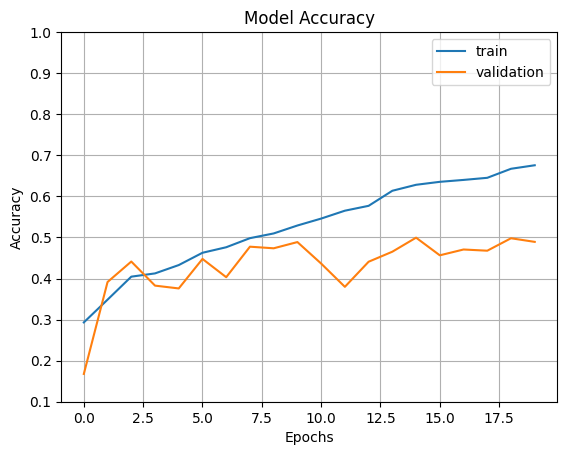

In [16]:
fig1 = plt.gcf()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.axis(ymin=0.1,ymax=1)
plt.grid()
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

Model Loss Graph Analysis 

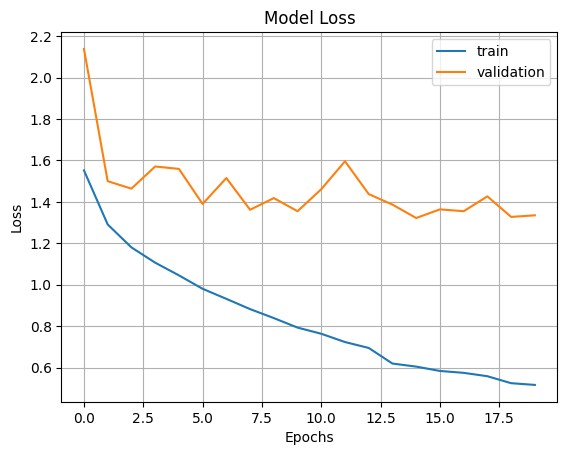

In [17]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.grid()
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

In [18]:
test_ds.take(1)

# Evaluating the model on the test set
loss, accuracy = resnet_50_model.evaluate(test_ds)
print(f'Test accuracy: {round(accuracy * 100, 2)}%')


160/160 [==============================] - 35s 217ms/step - loss: 1.3452 - accuracy: 0.5047
Test accuracy: 50.47%


# Making Predictions

160/160 [==============================] - 34s 204ms/step - loss: 1.3452 - accuracy: 0.5047
Evaluation results: [1.345246434211731, 0.5046911835670471]
160/160 [==============================] - 26s 150ms/step


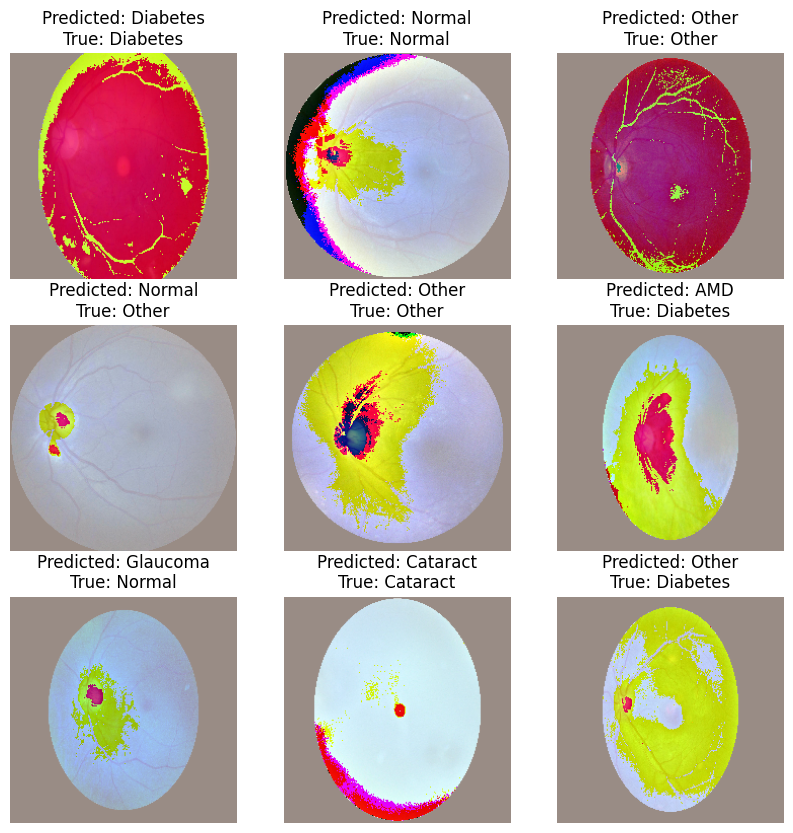

In [19]:
from tensorflow.keras.models import load_model

# Load the saved model
resnet_50_model = load_model('best_model_Resnet50.h5')

# Evaluate the model on the test dataset
evaluation_results = resnet_50_model.evaluate(test_ds)
print("Evaluation results:", evaluation_results)

# Generate predictions
predictions = resnet_50_model.predict(test_ds)

# Get the predicted classes
predicted_classes = np.argmax(predictions, axis=1)

class_labels = ['Normal', 'Diabetes', 'Glaucoma', 'Cataract', 'AMD', 'Hypertension', 'Myopia', 'Other']

# Define the number of images you want to display
num_images_to_display = 9

# Initialize lists to store the images and labels
display_images = []
display_labels = []

# Iterate over the dataset to collect images and labels
for images, labels in test_ds.unbatch().take(num_images_to_display):
    display_images.append(images)
    display_labels.append(labels)

# Now plot the images with predictions and true labels
plt.figure(figsize=(10, 10))
for i, image in enumerate(display_images):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image.numpy().astype("uint8"))
    true_label = class_labels[np.argmax(display_labels[i].numpy())]
    predicted_label = class_labels[predicted_classes[i]]
    plt.title(f"Predicted: {predicted_label}\nTrue: {true_label}")
    plt.axis("off")
plt.show()

# Predictions Result Evaluation

In [20]:
from sklearn.metrics import classification_report, balanced_accuracy_score, roc_auc_score

Classification Report 

In [21]:
# Let's check the shape of the unbatched labels
for _, label in test_ds.unbatch().take(1):
    print("Unbatched label shape:", label.numpy().shape)


Unbatched label shape: (8,)


In [22]:
# Collect the true labels from the unbatched dataset
true_labels = np.vstack([y.numpy() for _, y in test_ds.unbatch()])

# true_labels should now be a 2-dimensional array, you can verify by printing its shape
print("Shape of true_labels after vstack:", true_labels.shape)

# Convert one-hot encoded labels to class indices
true_classes = np.argmax(true_labels, axis=1)

Shape of true_labels after vstack: (2558, 8)


In [23]:
class_labels = ['Normal', 'Diabetes', 'Glaucoma', 'Cataract', 'AMD', 'Hypertension', 'Myopia', 'Other diseases']

# Now, the number of predicted classes should match the number of true classes
# Generate the classification report again
report = classification_report(true_classes, predicted_classes, target_names=class_labels, zero_division=0)

print(report)


                precision    recall  f1-score   support

        Normal       0.70      0.46      0.55      1150
      Diabetes       0.52      0.54      0.53       644
      Glaucoma       0.37      0.60      0.46       114
      Cataract       0.47      0.85      0.61       118
           AMD       0.30      0.70      0.42       106
  Hypertension       0.28      0.50      0.36        50
        Myopia       0.66      0.79      0.72        92
Other diseases       0.25      0.26      0.26       284

      accuracy                           0.50      2558
     macro avg       0.44      0.59      0.49      2558
  weighted avg       0.55      0.50      0.51      2558



Balanced Accuracy Score 

In [24]:
balanced_accuracy = balanced_accuracy_score(true_classes, predicted_classes)
print('Balanced Accuracy: {:.4f}'.format(balanced_accuracy))

Balanced Accuracy: 0.5874


Area Under the Reciever Operating Characteristic Curve (AUC-ROC)

In [25]:
from keras.utils import to_categorical
true_classes_one_hot = to_categorical(true_classes, num_classes=8)

# Calculate ROC AUC for multi-class classification
roc_auc = roc_auc_score(true_classes_one_hot, predictions, average='macro', multi_class='ovo')

print(f'ROC AUC: {roc_auc:.4f}')

ROC AUC: 0.8346


Confusion Matrix 

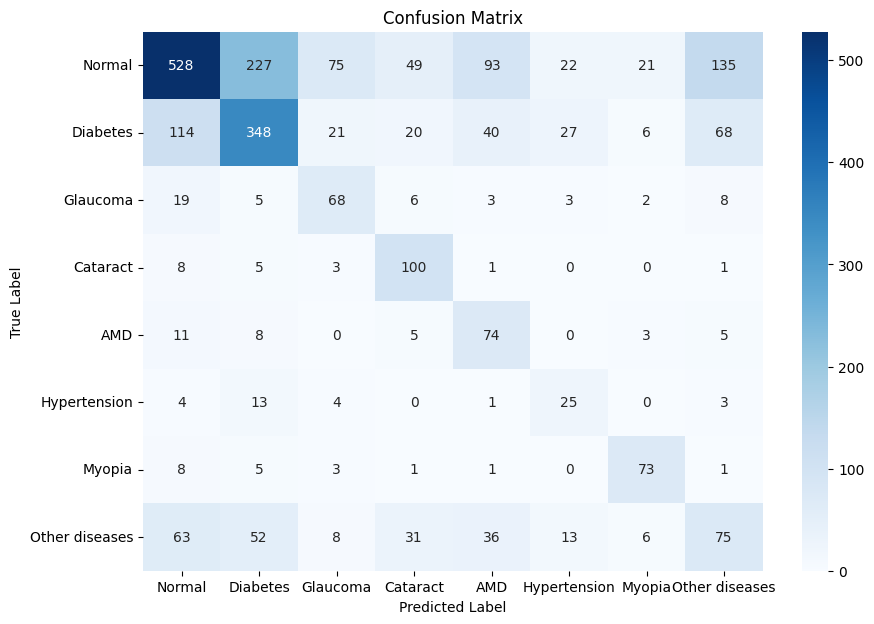

In [26]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Calculate confusion matrix
cm = confusion_matrix(true_classes, predicted_classes)

# Plot confusion matrix
plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# Prediction Evaluation

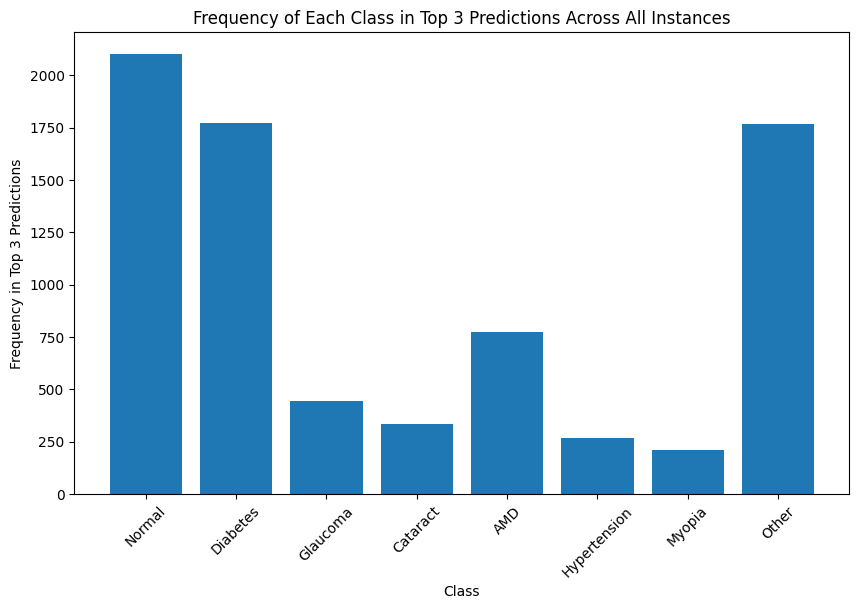

In [27]:
class_labels = ['Normal', 'Diabetes', 'Glaucoma', 'Cataract', 'AMD', 'Hypertension', 'Myopia', 'Other']

# Function to get top 3 indices for all predictions
def get_top3_indices(predictions):
    return predictions.argsort()[:, -3:]

# Count the frequency of each class being in the top 3
top3_indices = get_top3_indices(predictions)
class_counts = np.zeros(len(class_labels))

for indices in top3_indices:
    for index in indices:
        class_counts[index] += 1



# Plotting
plt.figure(figsize=(10, 6))
plt.bar(class_labels, class_counts)
plt.xlabel('Class')
plt.ylabel('Frequency in Top 3 Predictions')
plt.title('Frequency of Each Class in Top 3 Predictions Across All Instances')
plt.xticks(rotation=45)
plt.show()